In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hdf5storage
import time
import h5py
from torch.utils.data import Dataset, DataLoader

from core import losses
from core import model_utils
from core import data_loader
from core import models_seg

In [2]:
data_path = "/media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data"
model_path = data_path + "/models"

train_path = data_path + "/Ashitha/Transplant/Training"
x_folder = "Input_image_4C"
y_folder = "Ref_mask"
x_fnames = os.listdir(train_path + "/" + x_folder)
x_files = [os.path.join(train_path, x_folder, fname) for fname in x_fnames]
y_fnames = os.listdir(train_path + "/" + y_folder)
y_files = [os.path.join(train_path, y_folder, fname[:-9] + "mask.mat") for fname in x_fnames]
print(len(x_files))

325


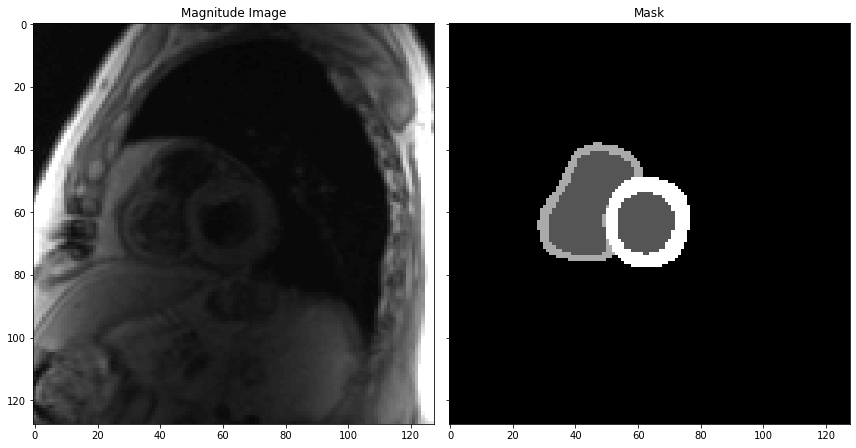

torch.Size([1, 4, 30, 128, 128]) torch.Size([1, 30, 128, 128])


In [4]:
import random
idx = random.randint(0,len(x_fnames)-1)
dataset = data_loader.Loader3D_TPM(x_files[idx:idx+1], y_files[idx:idx+1], imsize = 128,mode =None)
loader = DataLoader(dataset,
                 batch_size = 1,
                 shuffle = True,
                 drop_last = False,
                 num_workers = 1)
for batch_idx, data in enumerate(loader):
    x = data["x"]
    y = data["y"]
cy = y.data.numpy()
cx = x.data.numpy()
# print(cx.shape,cy.shape)
mag  = cx[0,0,5]*5
mask = cy[0,5]
vmin = 0
vmax= 3
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,8))
ax[0].imshow(mag, cmap = "gray", vmin = vmin, vmax = vmax)
ax[1].imshow(mask, cmap = "gray", vmin = vmin, vmax = vmax)

ax[0].set_title("Magnitude Image")
ax[1].set_title("Mask")

fig.tight_layout()
plt.show()
print(x.shape,y.shape)

In [5]:
gpu_no = "1"
device = torch.device("cuda:"+str(gpu_no) if torch.cuda.is_available() else "cpu")
batch_size = 1
epochs = 100
lr = 1e-4
print_step = 50
num_workers = 6
lamda = 10e3
################################### network ###############################
#  Unet_seg3D_2Dpool    Dense_Unet_3L
mrinet = models_seg.Dense_Unet_4L(features=64,drop_out = 0.05,in_channel = 4, classes = 4, mode = None).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mrinet.parameters()), lr = lr, betas = (0.9, 0.99))

In [6]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
exit_flag = False

model_name = "TPM_Seg_DenseUnet_CE_HD.pth"

for i in range(epochs):
    total_loss = 0
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, mrinet.parameters()), lr = lr, betas = (0.9, 0.99))
    dataset = data_loader.Loader3D_TPM(x_files, y_files, imsize = 128,mode =None)
    loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True,
                         drop_last = True,
                         num_workers = num_workers)
    
    if exit_flag:
        break

    try:
        for batch_idx, data in enumerate(loader):
            optimizer.zero_grad()
            loss = 0
            x = data["x"].to(device)
            y = data["y"].to(device)
            out = mrinet(x)  
            loss =  loss_fn(out, y)  + losses.AveragedHausdorffLoss(out, y, 0.5) # + losses.dice_loss_TPM(out, y)
            loss.backward()
            optimizer.step()
            total_loss = total_loss + loss.data.cpu().numpy()
            if (batch_idx+1)%print_step == 0:
                logging.info("Epoch {:},Batch = {:}, Learning Rate = {:.8f}, Loss= {:.8f}".format(i+1,(batch_idx+1)*batch_size,lr,total_loss/((batch_idx+1)*batch_size)))
    except KeyboardInterrupt:
        exit_flag = True
#     lr = lr*0.95
print("Exiting training")
mrinet.save(path = model_path, filename = model_name, optimizer=optimizer)

2021-03-16 11:11:49,152 Epoch 1,Batch = 50, Learning Rate = 0.00010000, Loss= 3.11757391
2021-03-16 11:13:37,962 Epoch 1,Batch = 100, Learning Rate = 0.00010000, Loss= 2.32330847
2021-03-16 11:15:27,619 Epoch 1,Batch = 150, Learning Rate = 0.00010000, Loss= 1.99835933
2021-03-16 11:17:19,061 Epoch 1,Batch = 200, Learning Rate = 0.00010000, Loss= 1.80037201
2021-03-16 11:19:10,780 Epoch 1,Batch = 250, Learning Rate = 0.00010000, Loss= 1.67981833
2021-03-16 11:20:57,256 Epoch 1,Batch = 300, Learning Rate = 0.00010000, Loss= 1.57827051
2021-03-16 11:23:44,346 Epoch 2,Batch = 50, Learning Rate = 0.00010000, Loss= 1.09526381
2021-03-16 11:25:33,074 Epoch 2,Batch = 100, Learning Rate = 0.00010000, Loss= 1.07803412
2021-03-16 11:27:24,465 Epoch 2,Batch = 150, Learning Rate = 0.00010000, Loss= 1.04968361
2021-03-16 11:29:14,913 Epoch 2,Batch = 200, Learning Rate = 0.00010000, Loss= 1.06001187
2021-03-16 11:31:03,564 Epoch 2,Batch = 250, Learning Rate = 0.00010000, Loss= 1.05733119
2021-03-16 1

Exiting training
model saved as: /media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data/models/TPM_Seg_DenseUnet_CE_HD.pth


In [7]:
train_path = data_path + "/Ashitha/Transplant/Testing"
x_folder = "Input_image_4C"
y_folder = "Ref_mask"
x_fnames = os.listdir(train_path + "/" + x_folder)
x_files = [os.path.join(train_path, x_folder, fname) for fname in x_fnames]
y_fnames = os.listdir(train_path + "/" + y_folder)
y_files = [os.path.join(train_path, y_folder, fname[:-9] + "mask.mat") for fname in x_fnames]

In [6]:
mrinet = models_seg.Unet_seg3D_2Dpool(features=64,drop_out = 0.05,in_channel = 4, classes = 4, mode = "res").to(device)
model_name = "TPM_Seg_4LUNet_HD_v2.pth"
mrinet.load(path = model_path, filename = model_name)

loaded: /media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data/models/TPM_Seg_4LUNet_HD_v2.pth


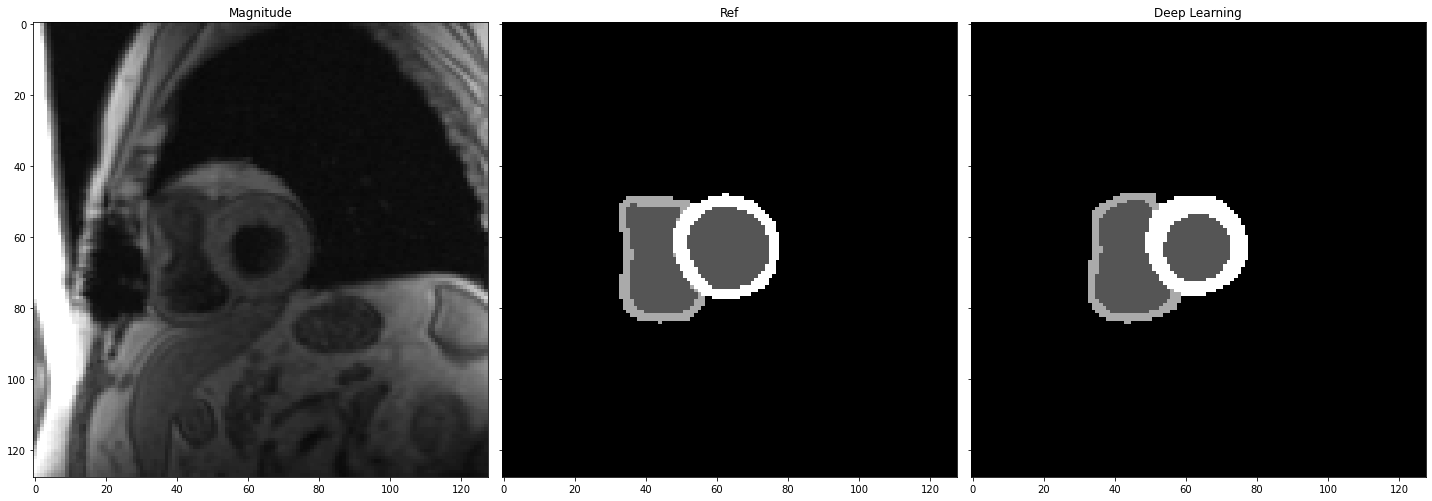

['/media/damingshen/05ba0687-eb77-48c2-a767-e9a44fbe94c1/Daming_data/Ashitha/Transplant/Testing/Input_image_4C/87510_073_RB_Year2_slice3_image.mat']


In [8]:
import random
idx = random.randint(0,len(x_fnames)-1)
dataset = data_loader.Loader3D_TPM(x_files[idx:idx+1], y_files[idx:idx+1], imsize = 128,mode =None)
loader = DataLoader(dataset,
                 batch_size = 1,
                 shuffle = True,
                 drop_last = False,
                 num_workers = 1)

for batch_idx, data in enumerate(loader):
            x = data["x"].to(device)
            y = data["y"].to(device)
# mrinet.to(device)         
mrinet.eval()   
out = mrinet(x)
out = torch.argmax(out,dim=1,keepdim =True)

cy = y.data.cpu().numpy()
cx = x.data.cpu().numpy()
cout = out.data.cpu().numpy()
# del out,x,y
torch.cuda.empty_cache()
t_frame = 5
mag = cx[0,0,t_frame]*5
mask = cy[0,t_frame] 
DL = cout[0,0,t_frame]

vmin = 0
vmax= 3
fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,15))
ax[0].imshow(np.abs(mag), cmap = "gray", vmin = vmin, vmax = vmax)
ax[1].imshow(np.abs(mask), cmap = "gray", vmin = vmin, vmax = vmax)
ax[2].imshow(np.abs(DL), cmap = "gray", vmin = vmin, vmax = vmax)

ax[0].set_title("Magnitude")
ax[1].set_title("Ref")
ax[2].set_title("Deep Learning")

fig.tight_layout()
plt.show()
print(x_files[idx:idx+1])

In [9]:
import logging
import scipy.io

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')
DL_folder = "Recon_DL/Dense_UNet_HD"
x_suffix="image.mat"
DL_suffix="Dense_UNet_HD.mat"
mrinet.eval()
for idx in range(len(x_files)):
    dataset = data_loader.Loader3D_TPM(x_files[idx:idx+1], y_files[idx:idx+1], imsize = 128,mode =None)
    loader = DataLoader(dataset,
                 batch_size = 1,
                 shuffle = False,
                 drop_last = False,
                 num_workers = 1)
    for batch_idx, data in enumerate(loader):
        x = data["x"].to(device)
#         y = data["y"].to(device)
    out = mrinet(x)
    out = torch.argmax(out,dim=1,keepdim =True)
    cout = out.data.cpu().numpy()
    cout = cout[0,0] 
    
    Dense_UNet_HD = np.squeeze(cout)
    
    x_file = x_files[idx]
    DL_file = x_file.replace(x_folder,DL_folder)
    DL_file = DL_file.replace(x_suffix,DL_suffix)
#     hdf5storage.savemat(DL_file, dict(UNet_Dice_HD = UNet_Dice_HD))
    scipy.io.savemat(DL_file, dict(Dense_UNet_HD = Dense_UNet_HD))

#     print(DL_file)
    logging.info(x_fnames[idx])

2021-03-17 10:19:45,022 87510_118_SP_Month3_slice1_image.mat
2021-03-17 10:19:45,909 87510_043_EB_12mo_Roberto_slice1_image.mat
2021-03-17 10:19:46,566 87510_035_DK_Year2_slice3_image.mat
2021-03-17 10:19:47,411 87510_115_JD_Month3_slice2_image.mat
2021-03-17 10:19:48,373 87510_120_TL_3mo_Roberto_slice1_image.mat
2021-03-17 10:19:49,222 87510_057_PB_Month3_slice1_image.mat
2021-03-17 10:19:49,905 87510_007_RL_1mo_Roberto_slice2_image.mat
2021-03-17 10:19:50,682 87510_105_DL_3mo_Roberto_slice3_image.mat
2021-03-17 10:19:51,470 87510_105_DL_3mo_Roberto_slice2_image.mat
2021-03-17 10:19:52,406 87510_075_JG_Year3_slice1_image.mat
2021-03-17 10:19:53,131 87510_119_LM_Month6_slice1_image.mat
2021-03-17 10:19:53,823 87510_062_SR_Month6_slice2_image.mat
2021-03-17 10:19:54,570 87510_106_MS_Month6_slice1_image.mat
2021-03-17 10:19:55,353 87510_073_RB_Year2_slice1_image.mat
2021-03-17 10:19:56,268 87510_069_AL_6mo_Roberto_slice2_image.mat
2021-03-17 10:19:57,067 87510_063_TL_6mo_Roberto_slice1_i